# Visualize Recorded Data

In [1]:
# Setup Libraries
import sys
sys.path = sys.path[2:]
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import cv2
import math
import numpy as np
import csv
import os

In [2]:
# Setup Tensorflow
import tensorflow as tf

In [3]:
# Setup Keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam


Using TensorFlow backend.


In [4]:
learning_rate = 0.001
batch_size = 128
epochs = 5

In [5]:
center_imgs_name = []
steering = []

with open('./data/driving_log.csv', mode='r') as infile:
    reader = csv.reader(infile)
    i = 0
    for rows in reader:
        if i is 0:
            i+=1
            continue
        center_imgs_name.append(rows[0])
        steering.append(float(rows[3]))

steering = np.array(steering)

In [6]:
def batch_generator(center_name,left_name,right_name,steering_list,operation):
    test_img = cv2.imread('./data/'+center_name[0])
    size = 0
    start = 0
    if(operation == 'train'):
        start = 0
        size = int(0.6*len(center_name))
    elif(operation == 'test'):
        start = int(0.8*len(center_name))
        size = int(0.2*len(center_name))
    elif(operation == 'valid'):
        start = int(0.6*len(center_name))
        size = int(0.2*len(center_name))
    elif(operation == 'viz'):
        start = int(np.random.rand()*len(center_name))
        size = 1
    images = np.empty([size,test_img.shape[0]-60-25,test_img.shape[1],test_img.shape[2]])
    steering = np.empty(size)
    index = 0
    for i in np.random.permutation(range(start,start+size)):
        image = cv2.imread('./data/'+center_name[i])[60:-25,:,:]
        image = cv2.cvtColor(image,cv2.COLOR_BGR2YUV)
        images[index] = image
        steering[index] = steering_list[i]
    yield images,steering

(75, 320, 3)


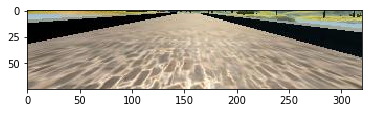

In [7]:
tt = batch_generator(center_imgs_name,None,None,steering,'viz')
sample_img, _ = next(tt)
sample_img = np.uint8(sample_img[0])
print(sample_img.shape)
plt.imshow(cv2.cvtColor(sample_img,cv2.COLOR_YUV2RGB))

In [8]:
model = Sequential()
model.add(Lambda(lambda x: (x-127.5)/127.5,input_shape=sample_img.shape))
model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 75, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 33, 64)         36928     
_______________________________________

In [9]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))
model.fit_generator(batch_generator(center_imgs_name,None,None,steering,'train'),batch_size,epochs,validation_data=batch_generator(center_imgs_name,None,None,steering,'valid'),nb_val_samples=0.2*len(center_imgs_name),verbose=1)

/home/ayush/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/home/ayush/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 128, 5, validation_data=<generator..., verbose=1, validation_steps=1607.2)`
  

Epoch 1/5


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[4821,24,36,158] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_1/convolution}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Mean/_179]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[4821,24,36,158] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_1/convolution}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.